In [18]:
import tvb.simulator.models
import tvb.simulator.integrators

import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Simulation parameters
with open('limit-cycle_simulation.pkl', 'rb') as f:
    simulation_params = pickle.load(f)

In [20]:
# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [21]:
X = simulation_params["simulation"]

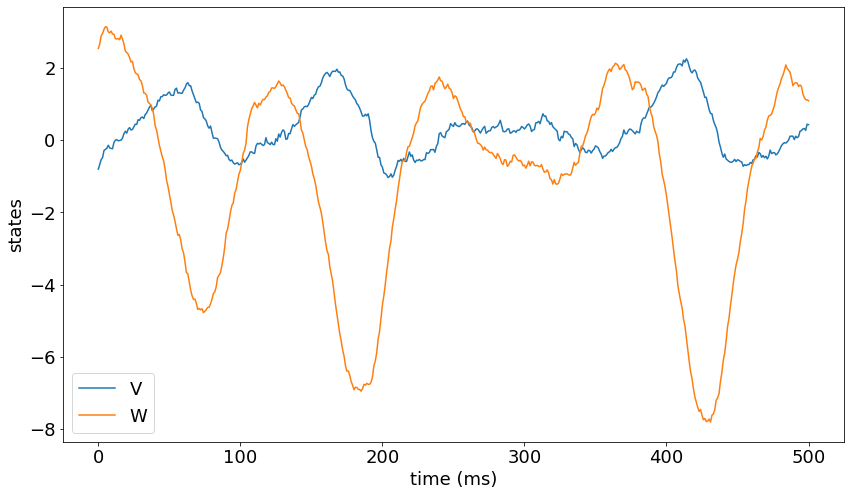

In [22]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states", fontsize=18)
plt.xlabel("time (ms)", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [23]:
# global inference parameters
shape = X.shape
draws = 500
tune = 500
num_cores = 2

### Inference using non-centered model

In [24]:
from tvb.contrib.inversion.pymcInference import NonCenteredModel

In [56]:
ncModel = NonCenteredModel(oscillator_model)

In [57]:
with ncModel.pymc_model:
    a_star = pm.Normal(name="a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic(name="a", var=2.0 + 0.01 * a_star)  #sd=1.0
    
    #b_star = pm.Normal(name="b_star", mu=0.0, sd=1.0)
    #b = pm.Deterministic(name="b", var=-10.0 + 0.1 * b_star)
    
    #c_star = pm.Normal(name="c_star", mu=0.0, sd=1.0)
    #c = pm.Deterministic(name="c", var=0.0 + 0.01 * c_star)
    
    #d_star = pm.Normal(name="d_star", mu=0.0, sd=1.0)
    #d = pm.Deterministic(name="d", var=0.02 + 0.001 * d_star)
    
    #I_star = pm.Normal(name="I_star", mu=0.0, sd=1.0)
    #I = pm.Deterministic(name="I", var=0.0 + 0.01 * I_star)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": np.array([simulation_params["b_sim"]]),
        "c": np.array([simulation_params["c_sim"]]),
        "d": np.array([simulation_params["d_sim"]]),
        "I": np.array([simulation_params["I_sim"]]),
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {
        "coupling": np.zeros([2, 1, 1]), 
        "local_coupling": 0.0
    }
    
    #x_init = pm.Normal("x_init", mu=0.0, sd=1.0, shape=shape[1:])
    x_init = theano.shared(X[0], name="x_init")
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # sd should be in the range of sqrt(2*nsig)
    #noise_star = BoundedNormal("noise_star", mu=0.0, sd=1.0)
    #noise = pm.Deterministic("noise", var=0.08 * noise_star)
    noise_star = BoundedNormal(name="noise_star", mu=0.0, sd=1.0)
    noise = pm.Deterministic(name="noise", var=0.05 + 0.1 * noise_star)
    
    x_t_star = pm.Normal(name="x_t_star", mu=0.0, sd=1.0, shape=tuple(shape))
    x_t = pm.Deterministic(name="x_t", var=noise * x_t_star)
    #x_t = pm.Deterministic(name="x_t", var=0.05 * x_t_star)
    
    amplitude_star = pm.Normal("amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic("amplitude", 0.0 + amplitude_star)
    
    offset_star = pm.Normal("offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic("offset", 0.0 + offset_star)
    
    epsilon = BoundedNormal(name="epsilon", mu=0.0, sd=1.0)

In [58]:
ncModel.set_model(
    priors=priors, 
    consts=consts, 
    obs=X, 
    time_step=dt,
    x_init=x_init,
    time_series=x_t,
    amplitude=amplitude,
    offset=offset,
    obs_noise=epsilon
)

In [59]:
nc_data = ncModel.run_inference(
    draws=draws,
    tune=tune,
    cores=num_cores,
    target_accept=0.9,
    max_treedepth=20,
    save=True
)

/Users/erichter/Documents/Uni/Charite/tvb/tvb-root/tvb_contrib/tvb/contrib/inversion/pymcInference.py:76: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = pm.sample(draws=draws, tune=tune, cores=cores, target_accept=target_accept, max_treedepth=max_treedepth)


2022-09-01 03:27:50,347 - ERROR - pymc3 - There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-09-01 03:27:50,365 - WARNING - pymc3 - The acceptance probability does not match the target. It is 0.9633083917363531, but should be close to 0.9. Try to increase the number of tuning steps.
2022-09-01 03:27:50,365 - ERROR - pymc3 - The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
2022-09-01 03:27:50,365 - ERROR - pymc3 - The estimated number of effective samples is smaller than 200 for some parameters.


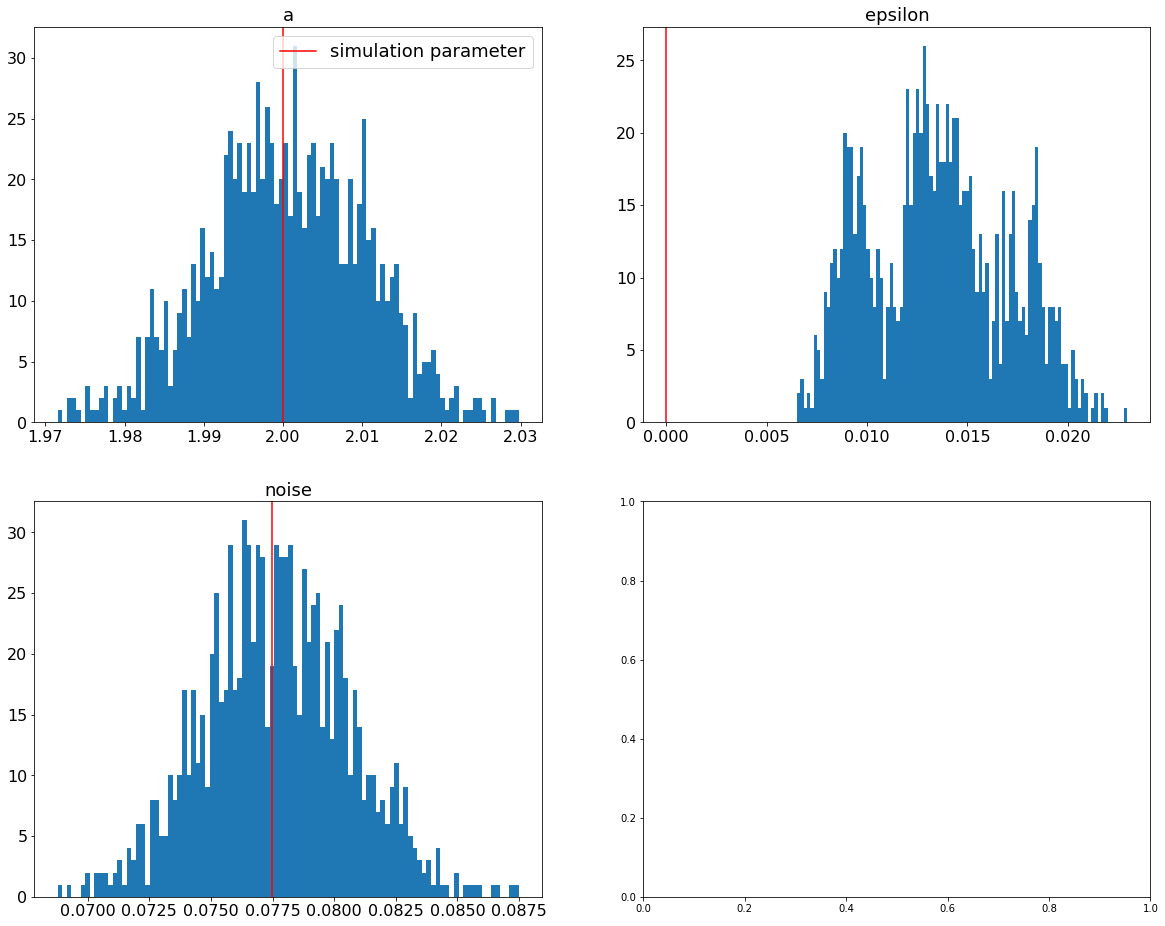

In [72]:
ncModel.plot_posterior_samples(
    init_params={"a": simulation_params["a_sim"], 
                 "epsilon": 0.0, 
                 "noise": np.sqrt(2 * simulation_params["nsig"])
                }
)

In [61]:
posterior_x_obs = nc_data.posterior_predictive.x_obs.values.reshape((num_cores*draws, *shape))

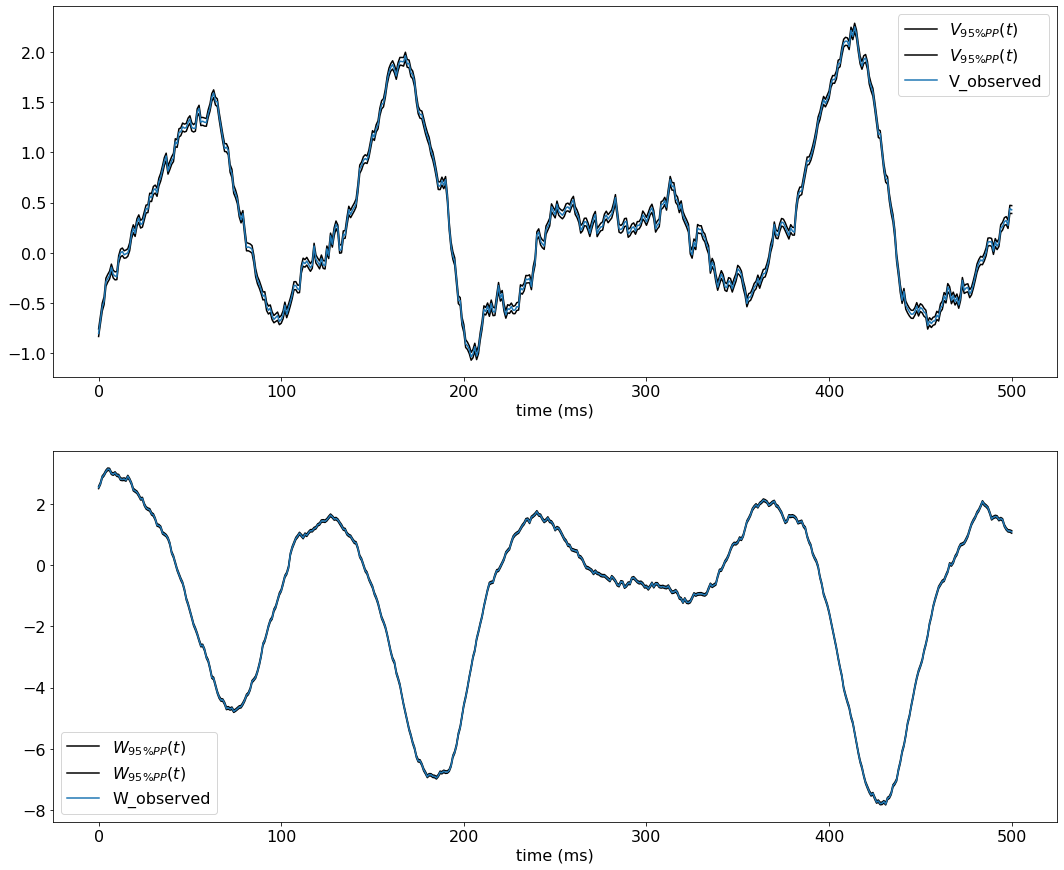

In [62]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
#axes3[0].plot(posterior_x_obs[0, :, 0, 0, 0])
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 1, 0, 0], label="W_observed")
#axes3[1].plot(posterior_x_obs[0, :, 1, 0, 0])
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [63]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [64]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

WAIC:  -5094.09074024527
LOO:  -4687.214408198011


In [ ]:
with ncModel.pymc_model:
    map_estimate = pm.find_MAP()

In [65]:
ncModel.summary[ncModel.summary["r_hat"] > 1.2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.014,0.003,0.008,0.02,0.002,0.002,3.0,12.0,1.81


In [66]:
ncModel.summary[ncModel.summary["ess_bulk"] < 200]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"x_t_star[0, 0, 0, 0]",-1.947,0.411,-2.712,-1.192,0.030,0.021,192.0,423.0,1.02
"x_t_star[65, 0, 0, 0]",-0.021,0.260,-0.477,0.490,0.037,0.026,55.0,691.0,1.03
"x_t_star[113, 1, 0, 0]",0.953,0.274,0.472,1.501,0.029,0.020,118.0,294.0,1.03
"x_t_star[118, 0, 0, 0]",2.038,0.262,1.519,2.486,0.029,0.021,120.0,63.0,1.03
"x_t_star[126, 0, 0, 0]",-1.111,0.254,-1.602,-0.655,0.039,0.028,47.0,500.0,1.03
...,...,...,...,...,...,...,...,...,...
"x_hat[431, 1, 0, 0]",-7.798,0.014,-7.823,-7.772,0.002,0.001,105.0,62.0,1.06
"x_hat[466, 1, 0, 0]",0.039,0.014,0.011,0.062,0.003,0.002,35.0,69.0,1.04
"x_hat[473, 0, 0, 0]",-0.283,0.014,-0.310,-0.259,0.002,0.002,35.0,167.0,1.04
"x_hat[484, 1, 0, 0]",2.073,0.014,2.045,2.098,0.002,0.001,76.0,510.0,1.03


In [67]:
x_hat_indezes = [index for index in ncModel.summary.index if "x_hat" in index]
ncModel.summary.loc[x_hat_indezes]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"x_hat[0, 0, 0, 0]",-0.797,0.014,-0.824,-0.774,0.001,0.001,311.0,258.0,1.02
"x_hat[0, 1, 0, 0]",2.540,0.013,2.513,2.563,0.000,0.000,1587.0,527.0,1.06
"x_hat[1, 0, 0, 0]",-0.672,0.014,-0.698,-0.645,0.000,0.000,1560.0,841.0,1.03
"x_hat[1, 1, 0, 0]",2.667,0.013,2.645,2.695,0.000,0.000,929.0,830.0,1.03
"x_hat[2, 0, 0, 0]",-0.541,0.013,-0.565,-0.515,0.000,0.000,1015.0,591.0,1.04
...,...,...,...,...,...,...,...,...,...
"x_hat[498, 1, 0, 0]",1.121,0.013,1.095,1.145,0.000,0.000,1653.0,360.0,1.04
"x_hat[499, 0, 0, 0]",0.434,0.014,0.406,0.458,0.001,0.000,529.0,500.0,1.07
"x_hat[499, 1, 0, 0]",1.116,0.013,1.094,1.143,0.000,0.000,1547.0,741.0,1.03
"x_hat[500, 0, 0, 0]",0.430,0.014,0.406,0.460,0.000,0.000,1050.0,778.0,1.05


In [69]:
ncModel.summary.loc[["a", "noise"]] #, "b", "c", "d", "I"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.000,0.010,1.983,2.019,0.000,0.0,1153.0,737.0,1.00
noise,0.078,0.003,0.072,0.083,0.001,0.0,26.0,109.0,1.07


In [70]:
divergent = ncModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(ncModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.trace['mean_tree_accept'].mean())

Number of Divergent 3
Percentage of Divergent 0.6
Mean tree accept 0.9


In [96]:
ncModel.save(simulation_params=simulation_params.copy())

### Inference using centered model

In [ ]:
from tvb.contrib.inversion.pymcInference import CenteredModel

In [ ]:
cModel = CenteredModel(oscillator_model)

In [ ]:
with cModel.pymc_model:
    a = pm.Normal("a", mu=-2.0, sd=1.0)
    
    b = pm.Normal("b", mu=-10.0, sd=1.0)
    
    c = pm.Normal("c", mu=0.0, sd=1.0)
    
    d = pm.Normal("d", mu=0.02, sd=1.0)
    
    I = pm.Normal("I", mu=0.0, sd=1.0)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": node_coupling, 
              "local_coupling": local_coupling}
    
    obs = {"x_obs": x_observed}
    
    time_step = integrator.dt
    
    x_init = pm.Normal("x_init", mu=0.0, sd=1.0, shape=shape[1:])
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=1.0)
    
    amplitude = pm.Normal("amplitude", mu=1.0, sd=1.0)
    
    offset = pm.Normal("offset", mu=0.0, sd=1.0)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [ ]:
cModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [ ]:
c_data = cModel.run_inference(draws=draws, tune=tune, cores=1, target_accept=0.9)

In [ ]:
cModel.plot_posterior(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [ ]:
posterior_x_obs = c_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))

In [ ]:
f5 = plt.figure(figsize=(14,8))
plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
plt.plot(t, x_observed[:, 0, 0, 0], label="V_observed")
plt.plot(t, x_observed[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
criteria = cModel.model_criteria(["WAIC", "LOO"])

In [ ]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

In [ ]:
log_likelihood = c_data.log_likelihood.x_obs.values.reshape((draws + tune, shape[0]))

In [ ]:
with cModel.pymc_model:
    map_estimate = pm.find_MAP()

In [ ]:
map_estimate

In [ ]:
cModel.summary

In [ ]:
divergent = cModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(cModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % cModel.trace['mean_tree_accept'].mean())